<a href="https://colab.research.google.com/github/Kermah225/Recommander/blob/main/SYSTEME_DE_RECOMMANDATION_DE_FILMS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install flask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#1. IMPORTATION DE LA BASE DE DONNEES




In [ ]:
import pandas as pd
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv').drop(['timestamp'],axis=1)

In [ ]:
import sqlite3

In [ ]:
conn = sqlite3.connect('recommender.db')
movies_df.to_sql('movies', conn, if_exists='replace', index=False)
ratings_df.to_sql('ratings', conn, if_exists='replace', index=False)


100836

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import threading
db_lock = threading.Lock()

#2. ANALYSE EXPLORATOIRE DES DONNEES

In [ ]:
import pandas as pd


# Afficher les premières lignes des DataFrames
print("Informations sur les films :")
print(movies_df.head())

print("\nNotes attribuées :")
print(ratings_df.head())

# Nombre de films et de notes
num_movies = movies_df.shape[0]
num_ratings = ratings_df.shape[0]

print("\nNombre total de films :", num_movies)
print("Nombre total de notes :", num_ratings)

# Statistiques descriptives des notes attribuées
ratings_stats = ratings_df['rating'].describe()
print("\nStatistiques des notes attribuées :\n", ratings_stats)

# Fusionner les DataFrames movies et ratings
merged_df = pd.merge(movies_df, ratings_df, on='movieId')

# Moyenne des notes par film
average_ratings = merged_df.groupby('movieId')['rating'].mean()

# Top 10 des films les mieux notés
top_10_movies = average_ratings.nlargest(10)
print("\nTop 10 des films les mieux notés :\n", top_10_movies)

# Nombre de genres uniques
unique_genres = movies_df['genres'].nunique()
print("\nNombre de genres uniques :", unique_genres)

# Distribution des genres
genre_counts = movies_df['genres'].value_counts()
print("\nDistribution des genres :\n", genre_counts)


Informations sur les films :
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Notes attribuées :
   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0

Nombre total de films : 9742
Nombre total de notes : 100836

Statistiques des notes attribuées :
 count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%

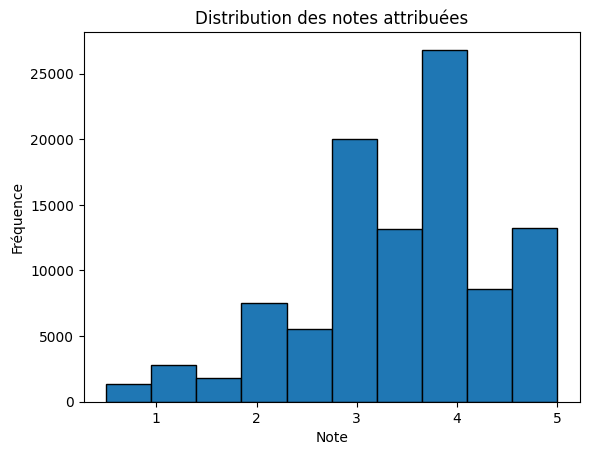

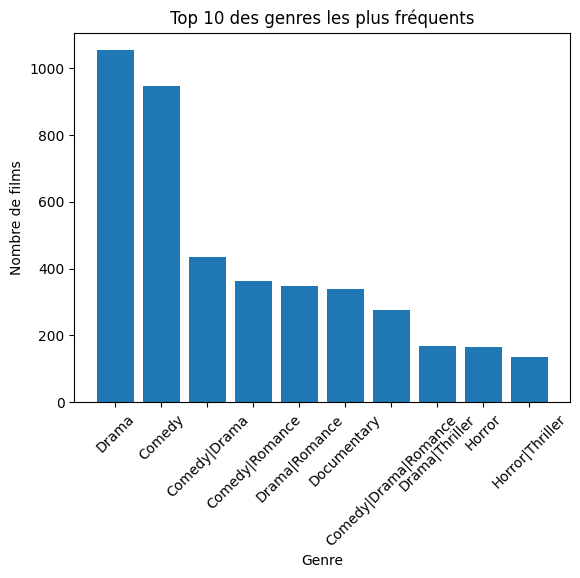

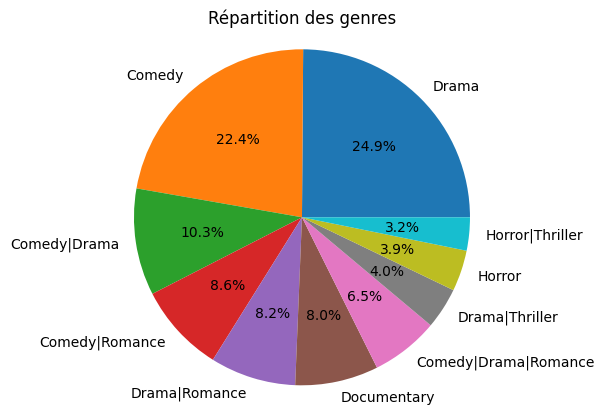

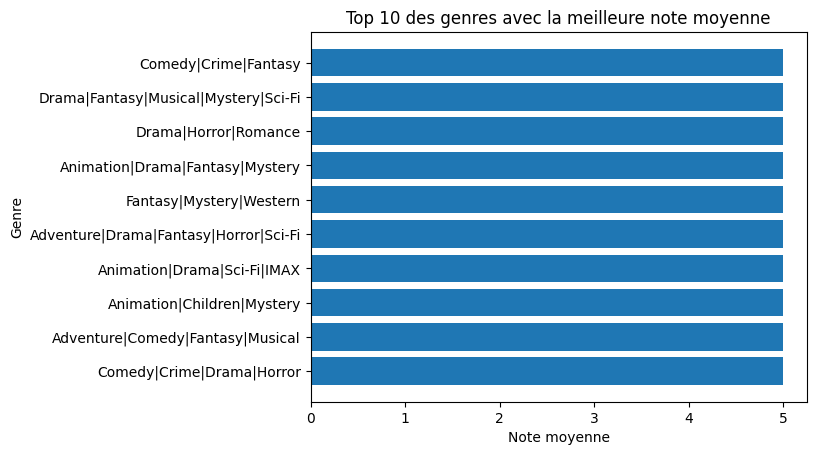

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Fusionner les DataFrames movies et ratings
merged_df = pd.merge(movies_df, ratings_df, on='movieId')

# Histogramme des notes attribuées
plt.hist(ratings_df['rating'], bins=10, edgecolor='black')
plt.xlabel('Note')
plt.ylabel('Fréquence')
plt.title('Distribution des notes attribuées')
plt.show()

# Nombre de films par genre
genre_counts = movies_df['genres'].value_counts().head(10)
plt.bar(genre_counts.index, genre_counts.values)
plt.xlabel('Genre')
plt.ylabel('Nombre de films')
plt.title('Top 10 des genres les plus fréquents')
plt.xticks(rotation=45)
plt.show()

# Diagramme à secteurs des genres
genre_percentages = movies_df['genres'].value_counts(normalize=True).head(10) * 100
plt.pie(genre_percentages, labels=genre_percentages.index, autopct='%1.1f%%')
plt.title('Répartition des genres')
plt.axis('equal')
plt.show()

# Moyenne des notes par genre
average_ratings_by_genre = merged_df.groupby('genres')['rating'].mean().sort_values(ascending=False).head(10)
plt.barh(average_ratings_by_genre.index, average_ratings_by_genre.values)
plt.xlabel('Note moyenne')
plt.ylabel('Genre')
plt.title('Top 10 des genres avec la meilleure note moyenne')
plt.show()


#3. LES METHODES DE SYSTEME DE RECOMMANDATION

##SYSTEME DE RECOMMANDATION BASE SUR LE CONTENU
Dans notre cas, il s'agit du genre du film.

In [ ]:
def content_based_recommendation(movie_title, top_n=5):
    # Créer une instance de CountVectorizer pour représenter les genres
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'))
    genre_matrix = vectorizer.fit_transform(movies_df['genres'])

    # Trouver l'index du film donné
    movie_index = movies_df[movies_df['title'] == movie_title].index[0]

    # Calculer les similarités cosinus entre les films
    similarities = cosine_similarity(genre_matrix, genre_matrix[movie_index])

    # Récupérer les indices des films similaires
    similar_indices = similarities.argsort(axis=0)[-top_n-1:-1][::-1]

    # Récupérer les films similaires
    similar_movies = movies_df.iloc[similar_indices.flatten()].copy()

    return similar_movies

#Exemple
content_based_recommendation('Toy Story (1995)', top_n=5)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,movieId,title,genres
8219,103755,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy
3568,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
9430,166461,Moana (2016),Adventure|Animation|Children|Comedy|Fantasy
3000,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
2809,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy


##SYSTEME DE RECOMMANDATION BASE SUR L'UTILISATEUR
Dans notre cas, on se basera sur les préférences de l'utilisateur en termes de genres de film.

In [ ]:
# Fonction pour obtenir les recommandations basées sur les genres préférés de l'utilisateur
def get_genre_preferences(user_id):
    # Obtenez les films notés par l'utilisateur
    user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId']

    # Calculez la moyenne des notes pour chaque genre de film
    genre_ratings = movies_df[movies_df['movieId'].isin(user_movies)].merge(ratings_df, on='movieId')
    genre_preferences = genre_ratings.groupby('genres')['rating'].mean().reset_index()

    # Divisez les genres en catégories individuelles
    genre_preferences['genres'] = genre_preferences['genres'].str.split('|')
    genre_preferences = genre_preferences.explode('genres')

    # Triez les genres par note moyenne décroissante
    genre_preferences = genre_preferences.groupby('genres')['rating'].mean().reset_index()
    genre_preferences = genre_preferences.sort_values('rating', ascending=False)

    return genre_preferences

# Fonction pour obtenir les recommandations de films basées sur les genres préférés de l'utilisateur
def get_genre_based_recommendations(user_id, top_n=5):
    # Obtenez les genres préférés de l'utilisateur
    genre_preferences = get_genre_preferences(user_id)
    top_genres = genre_preferences.head(top_n)['genres']

    # Obtenez les films non visionnés par l'utilisateur
    user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId']
    unwatched_movies = movies_df[~movies_df['movieId'].isin(user_movies)]

    # Sélectionnez les films du même genre que les genres préférés de l'utilisateur
    genre_based_recommendations = unwatched_movies[unwatched_movies['genres'].apply(lambda x: any(genre in x for genre in top_genres))]

       # Fusionnez les données de notation pour obtenir les informations de notation nécessaires
    genre_based_recommendations = genre_based_recommendations.merge(ratings_df, on='movieId')

    # Triez les films par rating décroissant
    genre_based_recommendations = genre_based_recommendations.sort_values('rating', ascending=False).drop_duplicates('title').head(top_n)

    #
    return genre_based_recommendations.drop(['userId','rating'], axis=1)

# Exemple d'utilisation
user_id = 1
get_genre_based_recommendations(user_id)



,movieId,title,genres
25648,3668,Romeo and Juliet (1968),Drama|Romance
9284,898,"Philadelphia Story, The (1940)",Comedy|Drama|Romance
23078,3100,"River Runs Through It, A (1992)",Drama
23070,3099,Shampoo (1975),Comedy|Drama|Romance
34991,6947,Master and Commander: The Far Side of the Worl...,Adventure|Drama|War


#DEPLOIEMENT DU SYSTEME SOUS FLASK

Travaillant sur collab, nous avons été obligé d'utiliser ngrok pour simuler le localhost

In [ ]:
!pip install flask-ngrok --quiet
print("Completed!")

Completed!


In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz

--2023-06-13 16:25:49--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 52.202.168.65, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13856790 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.tgz.3’

ngrok-stable-linux- 100%[===================>]  13.21M  54.8MB/s    in 0.2s    

2023-06-13 16:25:50 (54.8 MB/s) - ‘ngrok-stable-linux-amd64.tgz.3’ saved [13856790/13856790]



In [ ]:
!tar -xvf /content/ngrok-stable-linux-amd64.tgz

ngrok


In [ ]:
!./ngrok authtoken 23H0IY10fqeKMIW7kG05JhKZMae_3Zabr2iqkU9AUcZ7CrRTP

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


##IMPORTATION DES FICHIERS DE BOOTSTRAP ET JS QUERY

In [ ]:
import requests

# URL des fichiers CSS et JavaScript de jQuery
css_url = 'https://code.jquery.com/jquery-3.6.0.min.js'
js_url = 'https://code.jquery.com/jquery-3.6.0.min.js'

# Téléchargement du fichier CSS
response = requests.get(css_url)
with open('static/css/jquery.min.css', 'wb') as file:
    file.write(response.content)

# Téléchargement du fichier JavaScript
response = requests.get(js_url)
with open('static/js/jquery.min.js', 'wb') as file:
    file.write(response.content)


In [ ]:
import requests

# URL du fichier CSS de Font Awesome
css_url = 'https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.3/css/all.min.css'

# Téléchargement du fichier CSS
response = requests.get(css_url)
with open('static/css/font-awesome.min.css', 'wb') as file:
    file.write(response.content)


In [ ]:
valid_user_ids = list(ratings_df['userId'].unique())
valid_movie_titles = list(movies_df['title'].unique())

##DEPLOIEMENT SUR FLASK

In [ ]:
§

In [ ]:
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)

In [ ]:
@app.route('/')
def Index():
  valid_user_ids = list(ratings_df['userId'].unique())
  valid_movie_titles = list(movies_df['title'].unique())
  return render_template('index.html',
                         valid_user_ids=valid_user_ids,
                         valid_movie_titles=valid_movie_titles )

@app.route('/Recommend', methods=['POST'])
def Recommend():
    movie_title = request.form['title']
    user_id = request.form['user_id']

    # Appeler les fonctions de recommandation
    content_based_results = content_based_recommendation(movie_title)
    collaborative_filtering_result = get_genre_based_recommendations(int(user_id),top_n=5)

    return render_template('recommend.html',
                           movie_title=movie_title,
                           user_id=user_id,
                           content_based_results=content_based_results,
                           collaborative_filtering_results=collaborative_filtering_result)


In [ ]:
app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://c126-34-74-227-14.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [13/Jun/2023 17:05:24] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [13/Jun/2023 17:05:24] "GET /static/css/bootstrap.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [13/Jun/2023 17:05:24] "GET /static/js/jquery.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [13/Jun/2023 17:05:24] "GET /static/css/font-awesome.min.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [13/Jun/2023 17:05:24] "GET /static/js/bootstrap.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [13/Jun/2023 17:05:27] "GET /static/images/Toystory.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [13/Jun/2023 17:05:27] "GET /static/images/quantumania.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [13/Jun/2023 17:05:27] "GET /static/images/fast&Furious.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [13/Jun/2023 17:05:27] "GET /static/images/cinema-bg.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [13/Jun/2023 17:05:32] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!zip -r /content/static.zip /content/static

updating: content/static/ (stored 0%)
updating: content/static/.ipynb_checkpoints/ (stored 0%)
updating: content/static/images/ (stored 0%)
updating: content/static/images/.ipynb_checkpoints/ (stored 0%)
updating: content/static/images/Toystory.jpg (deflated 0%)
updating: content/static/images/quantumania.jpg (deflated 0%)
updating: content/static/images/cinema-bg.jpg (deflated 0%)
updating: content/static/images/fast&Furious.jpg (deflated 0%)
updating: content/static/js/ (stored 0%)
updating: content/static/js/jquery.min.js (deflated 66%)
updating: content/static/js/bootstrap.js (deflated 80%)
updating: content/static/js/bootstrap.bundle.min.js (deflated 71%)
updating: content/static/js/bootstrap.min.js.map (deflated 75%)
updating: content/static/js/bootstrap.esm.js (deflated 79%)
updating: content/static/js/bootstrap.js.map (deflated 79%)
updating: content/static/js/bootstrap.bundle.js (deflated 79%)
updating: content/static/js/bootstrap.esm.min.js (deflated 75%)
updating: content/st

In [ ]:
!zip -r /content/templates.zip /content/templates

  adding: content/templates/ (stored 0%)
  adding: content/templates/.ipynb_checkpoints/ (stored 0%)
  adding: content/templates/index.html (deflated 62%)
  adding: content/templates/recommend.html (deflated 58%)


In [ ]:
from google.colab import files
files.download('/content/static.zip')
files.download('/content/templates.zip')
files.download('/content/ngrok')
files.download('/content/recommender.db')
files.download('/content/ngrok-stable-linux-amd64.tgz')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>